# Class Imbalance Techniques



In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load Dataset

The following dataset is a well-known imbalanced dataset from Kaggle:
    https://www.kaggle.com/mlg-ulb/creditcardfraud/home?select=creditcard.csv

In [3]:
df = pd.read_csv('../data/creditcard_sample.csv')
# df.info()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Take a random sample, and then create X, y variables, and then split into training and testing.

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(['Class'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [6]:
y_train.value_counts()
y_test.value_counts()

0    113707
1       215
Name: Class, dtype: int64

0    28427
1       54
Name: Class, dtype: int64

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score

# Helper function
def quick_evaluate_with_dt(X_train, X_test, y_train, y_test, name, balance_weights=False):
    
    cw = None
    if balance_weights == True:
        cw = 'balanced'
        
    clf = DecisionTreeClassifier(random_state=0, class_weight=cw)
    #clf = RandomForestClassifier(random_state=0, n_estimators=100, class_weight=cw)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy       = accuracy_score(y_test, y_pred)
    f1             = f1_score(y_test, y_pred)
    recall         = recall_score(y_test, y_pred)
    precision      = precision_score(y_test, y_pred)
    roc_auc        = roc_auc_score(y_test, y_pred)
    
    df = pd.DataFrame({"Method"    : [name],
                       "Neg"       : [tn + fn],
                       "True Neg"  : [tn],
                       "False Neg" : [fn],
                       "Pos"       : [tp + fp],
                       "TP"        : [tp],
                       "FP"        : [fp],
                       "Accuracy"  : [accuracy],
                       "Recall"    : [recall],
                       "Precision" : [precision],
                       "F1"        : [f1],
                       "AUC"       : [roc_auc],
                      })
    
    print(df)
    return df

# Sourced From: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
def plot_roc(clf, Xf_test, Yf_test, name, ax, show_thresholds=False):
    Yf_pred_rf = clf.predict_proba(Xf_test)[:, 1]
    fpr, tpr, thr = roc_curve(Yf_test, Yf_pred_rf)

    ax.plot([0, 1], [0, 1], 'k--');
    ax.plot(fpr, tpr, label='{}, AUC={:.2f}'.format(name, auc(fpr, tpr)));
    ax.scatter(fpr, tpr);

    if show_thresholds:
        for i, th in enumerate(thr):
            ax.text(x=fpr[i], y=tpr[i], s="{:.2f}".format(th), fontsize=14, 
                     horizontalalignment='left', verticalalignment='top', color='black',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1', alpha=0.1));
        
    ax.set_xlabel('False positive rate', fontsize=18);
    ax.set_ylabel('True positive rate', fontsize=18);
    ax.tick_params(axis='both', which='major', labelsize=18);
    ax.grid(True);
    ax.set_title('ROC Curve', fontsize=18)

In [9]:
evals = list()

In [10]:
X_train.shape
y_train.shape
np.bincount(y_train)

evals.append(quick_evaluate_with_dt(X_train, X_test, y_train, y_test, 'None'))

(113922, 30)

(113922,)

array([113707,    215], dtype=int64)

  Method    Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0   None  28429     28414         15   52  39  13  0.999017  0.722222   

   Precision        F1       AUC  
0       0.75  0.735849  0.860882  


In [11]:
X_train.shape
y_train.shape
np.bincount(y_train)

evals.append(quick_evaluate_with_dt(X_train, X_test, y_train, y_test, 'Class Weights', balance_weights=True))

(113922, 30)

(113922,)

array([113707,    215], dtype=int64)

          Method    Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0  Class Weights  28431     28416         15   50  39  11  0.999087  0.722222   

   Precision    F1       AUC  
0       0.78  0.75  0.860918  


In [12]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
X_resampled.shape
y_resampled.shape
np.bincount(y_resampled)

evals.append(quick_evaluate_with_dt(X_resampled, X_test, y_resampled, y_test, 'Over Random'))

(227414, 30)

(227414,)

array([113707, 113707], dtype=int64)

        Method    Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0  Over Random  28433     28418         15   48  39   9  0.999157  0.722222   

   Precision        F1       AUC  
0     0.8125  0.764706  0.860953  


In [13]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=0).fit_resample(X_train, y_train)

X_resampled.shape
y_resampled.shape
np.bincount(y_resampled)

evals.append(quick_evaluate_with_dt(X_resampled, X_test, y_resampled, y_test, 'Over SMOTE'))

(227414, 30)

(227414,)

array([113707, 113707], dtype=int64)

       Method    Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0  Over SMOTE  28399     28386         13   82  41  41  0.998104  0.759259   

   Precision        F1       AUC  
0        0.5  0.602941  0.878908  


In [14]:
from imblearn.over_sampling import ADASYN

X_resampled, y_resampled = ADASYN(random_state=0).fit_resample(X_train, y_train)

X_resampled.shape
y_resampled.shape
np.bincount(y_resampled)

evals.append(quick_evaluate_with_dt(X_resampled, X_test, y_resampled, y_test,  'Over ADASYN'))

(227369, 30)

(227369,)

array([113707, 113662], dtype=int64)

        Method    Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0  Over ADASYN  28398     28382         16   83  38  45  0.997858  0.703704   

   Precision        F1      AUC  
0   0.457831  0.554745  0.85106  


In [15]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

X_resampled.shape
y_resampled.shape
np.bincount(y_resampled)

evals.append(quick_evaluate_with_dt(X_resampled, X_test, y_resampled, y_test,  'Under Sample'))

(430, 30)

(430,)

array([215, 215], dtype=int64)

         Method    Neg  True Neg  False Neg   Pos  TP    FP  Accuracy  \
0  Under Sample  25520     25515          5  2961  49  2912  0.897581   

     Recall  Precision        F1       AUC  
0  0.907407   0.016548  0.032504  0.902485  


In [16]:
# Recall the actual distrition of the truth labels of the testing set.
y_test.value_counts()

evals_all = pd.concat([m for m in evals], axis = 0).reset_index()

evals_all = evals_all.drop(columns = "index",axis =1)
evals_all.sort_values(by=['F1'], ascending=False)

0    28427
1       54
Name: Class, dtype: int64

,Method,Neg,True Neg,False Neg,Pos,TP,FP,Accuracy,Recall,Precision,F1,AUC
2,Over Random,28433,28418,15,48,39,9,0.999157,0.722222,0.812500,0.764706,0.860953
1,Class Weights,28431,28416,15,50,39,11,0.999087,0.722222,0.780000,0.750000,0.860918
0,None,28429,28414,15,52,39,13,0.999017,0.722222,0.750000,0.735849,0.860882
3,Over SMOTE,28399,28386,13,82,41,41,0.998104,0.759259,0.500000,0.602941,0.878908
4,Over ADASYN,28398,28382,16,83,38,45,0.997858,0.703704,0.457831,0.554745,0.851060
5,Under Sample,25520,25515,5,2961,49,2912,0.897581,0.907407,0.016548,0.032504,0.902485


NameError: name 'plot_roc' is not defined

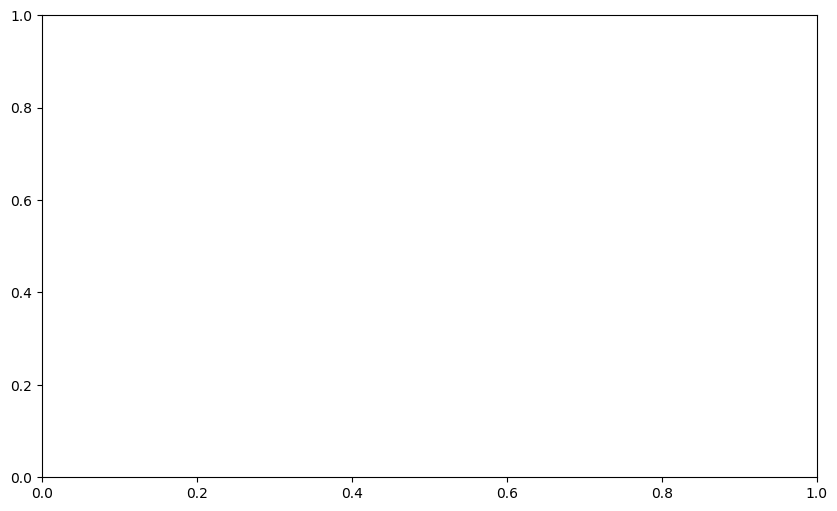

In [4]:
# Print Comparative ROC Curves for Each Model (Training)w/ AUC Score

plt.style.use('default');
figure = plt.figure(figsize=(10, 6));    
ax = plt.subplot(1, 1, 1);
plot_roc(clf_dt, Xf_test, Yf_test, "Decision Tree Test", ax)
plot_roc(clf_rf, Xf_test, Yf_test, "Random Forest Test", ax)
plot_roc(clf_nb, Xf_test, Yf_test, "Naive Bayes Test", ax)
plot_roc(clf_xgb, Xf_test, Yf_test, "XG Boost Test", ax)
plot_roc(clf_lr, Xf_test, Yf_test, "Logistic Regression Test", ax)
plt.legend(loc='lower right', fontsize=18);
plt.tight_layout();

# Another Dataset

The dataset is also imbalanced, although less so. It comes from:

https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [10]:
df_d = pd.read_csv('../data/diabetes_orig.csv')
df_d.info()
df_d.head()

X = df_d.drop(['Id', 'diabetes'], axis=1)
y = df_d['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=44)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  768 non-null    int64  
 1   num_times_pregnant  768 non-null    int64  
 2   plasma_glucose      768 non-null    int64  
 3   DBP                 768 non-null    int64  
 4   triceps_skin        768 non-null    int64  
 5   serum_insulin       768 non-null    int64  
 6   BMI                 768 non-null    float64
 7   pedigree            768 non-null    float64
 8   age                 768 non-null    int64  
 9   diabetes            768 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 60.1 KB


,Id,num_times_pregnant,plasma_glucose,DBP,triceps_skin,serum_insulin,BMI,pedigree,age,diabetes
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


In [11]:
y_train.value_counts()
y_test.value_counts()

0    400
1    214
Name: diabetes, dtype: int64

0    100
1     54
Name: diabetes, dtype: int64

In [12]:
evals_d = list()

In [13]:
X_train.shape
y_train.shape
np.bincount(y_train)

evals_d.append(quick_evaluate_with_dt(X_train, X_test, y_train, y_test, 'None'))

(614, 8)

(614,)

array([400, 214], dtype=int64)

  Method  Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0   None  116        88         28   38  26  12   0.74026  0.481481   

   Precision        F1       AUC  
0   0.684211  0.565217  0.680741  


In [14]:
X_train.shape
y_train.shape
np.bincount(y_train)

evals_d.append(quick_evaluate_with_dt(X_train, X_test, y_train, y_test, 'Class Weights', balance_weights=True))

(614, 8)

(614,)

array([400, 214], dtype=int64)

          Method  Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0  Class Weights  116        88         28   38  26  12   0.74026  0.481481   

   Precision        F1       AUC  
0   0.684211  0.565217  0.680741  


In [15]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
X_resampled.shape
y_resampled.shape
np.bincount(y_resampled)

evals_d.append(quick_evaluate_with_dt(X_resampled, X_test, y_resampled, y_test, 'Over Random'))

(800, 8)

(800,)

array([400, 400], dtype=int64)

        Method  Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0  Over Random  110        86         24   44  30  14  0.753247  0.555556   

   Precision        F1       AUC  
0   0.681818  0.612245  0.707778  


In [16]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=0).fit_resample(X_train, y_train)

X_resampled.shape
y_resampled.shape
np.bincount(y_resampled)

evals_d.append(quick_evaluate_with_dt(X_resampled, X_test, y_resampled, y_test, 'Over SMOTE'))

(800, 8)

(800,)

array([400, 400], dtype=int64)

       Method  Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0  Over SMOTE  107        84         23   47  31  16  0.746753  0.574074   

   Precision        F1       AUC  
0   0.659574  0.613861  0.707037  


In [17]:
from imblearn.over_sampling import ADASYN

X_resampled, y_resampled = ADASYN(random_state=0).fit_resample(X_train, y_train)

X_resampled.shape
y_resampled.shape
np.bincount(y_resampled)

evals_d.append(quick_evaluate_with_dt(X_resampled, X_test, y_resampled, y_test,  'Over ADASYN'))

(775, 8)

(775,)

array([400, 375], dtype=int64)

        Method  Neg  True Neg  False Neg  Pos  TP  FP  Accuracy   Recall  \
0  Over ADASYN  101        81         20   53  34  19  0.746753  0.62963   

   Precision        F1       AUC  
0   0.641509  0.635514  0.719815  


In [18]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

X_resampled.shape
y_resampled.shape
np.bincount(y_resampled)

evals_d.append(quick_evaluate_with_dt(X_resampled, X_test, y_resampled, y_test,  'Under Sample'))

(428, 8)

(428,)

array([214, 214], dtype=int64)

         Method  Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0  Under Sample   92        73         19   62  35  27  0.701299  0.648148   

   Precision        F1       AUC  
0   0.564516  0.603448  0.689074  


In [19]:
# Recall the actual distrition of the truth labels of the testing set.
y_test.value_counts()

evals_d_all = pd.concat([m for m in evals_d], axis = 0).reset_index()

evals_d_all = evals_d_all.drop(columns = "index",axis =1)
evals_d_all.sort_values(by=['F1'], ascending=False)

0    100
1     54
Name: diabetes, dtype: int64

,Method,Neg,True Neg,False Neg,Pos,TP,FP,Accuracy,Recall,Precision,F1,AUC
4,Over ADASYN,101,81,20,53,34,19,0.746753,0.629630,0.641509,0.635514,0.719815
3,Over SMOTE,107,84,23,47,31,16,0.746753,0.574074,0.659574,0.613861,0.707037
2,Over Random,110,86,24,44,30,14,0.753247,0.555556,0.681818,0.612245,0.707778
5,Under Sample,92,73,19,62,35,27,0.701299,0.648148,0.564516,0.603448,0.689074
0,None,116,88,28,38,26,12,0.740260,0.481481,0.684211,0.565217,0.680741
1,Class Weights,116,88,28,38,26,12,0.740260,0.481481,0.684211,0.565217,0.680741
